# Bildverarbeitung Belegarbeit 2

Willkommen zu dieser praktischen Übung zur Bildverarbeitung! In diesem Notebook werden wir uns mit fundamentalen Techniken zur Bildfilterung, Segmentierung und Merkmalsextraktion beschäftigen.

Das Ziel bleibt dasselbe: Wir werden diese Methoden **von Grund auf implementieren**, um ein tiefes Verständnis für die zugrunde liegenden Algorithmen und Operationen zu entwickeln, anstatt nur fertige Bibliotheksfunktionen zu verwenden.

Wir werden uns durch eine typische Pipeline der Bildanalyse arbeiten:

1.  **Filter-Operatoren**: Wir beginnen mit der Rauschunterdrückung und Bildverbesserung. Sie werden zwei essenzielle Filter implementieren:
    * Den **Median-Filter** als robusten, nicht-linearen Ansatz zur Entfernung von Ausreißern (z.B. Salz-und-Pfeffer-Rauschen).
    * Die **2D-Faltung (conv2d)** als Basis für lineare Filter (z.B. Glättung oder Kantenhervorhebung durch eigene Filterkerne).

2.  **Automatische Schwellenwertfindung (Thresholding)**: Um Bilder in Vorder- und Hintergrund zu trennen (Binarisierung), implementieren wir zwei klassische automatische Verfahren:
    * Einen **iterativen Algorithmus**, der den Schwellenwert schrittweise verfeinert, bis er konvergiert.
    * Die **Methode von Otsu**, ein statistischer Ansatz, der die Varianz zwischen den Klassen maximiert.

3.  **Morphologische Operatoren**: Aufbauend auf den binarisierten Bildern, werden wir die **Öffnung (Opening)** implementieren. Sie lernen, wie diese Operation (eine Kombination aus Erosion und Dilatation) genutzt wird, um Rauschen zu entfernen und die Konturen von Objekten zu glätten.

4.  **Hough-Transformation**: Zum Abschluss widmen wir uns der Merkmalsextraktion. Wir implementieren die Hough-Transformation, eine leistungsstarke Technik, um geometrische Formen – in unserem Fall **Linien** – in einem Bild zu detektieren, selbst wenn diese lückenhaft oder verrauscht sind.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

## Teil 1: Filter-Operatoren zur Rauschunterdrückung

In der realen Welt sind Bilder selten perfekt. Sie enthalten oft Rauschen, das durch den Aufnahmesensor, die Datenübertragung oder andere Störungen entsteht. Das Ziel der Bildfilterung ist es, dieses Rauschen zu unterdrücken und gleichzeitig wichtige Bildstrukturen (wie Kanten) so gut wie möglich zu erhalten.

In dieser ersten Aufgabe werden wir unsere Filter auf ein Bild anwenden, das mit **Salz-und-Pfeffer-Rauschen** (Salt-and-Pepper-Noise) versehen ist. Diese Rauschart zeichnet sich durch einzelne, zufällig verteilte Pixel aus, die entweder den maximalen (weiß, "Salz") oder den minimalen (schwarz, "Pfeffer") Helligkeitswert annehmen.

Wir werden zwei fundamentale Filtertypen von Grund auf implementieren, um dieses Rauschen zu bekämpfen: einen linearen und einen nicht-linearen Ansatz.

### Der 3x3 Box-Filter (Lineare Faltung)

Der **3x3 Box-Filter** (auch Mittelwertfilter genannt) ist ein klassischer linearer Glättungsfilter. Er ersetzt den Wert jedes Pixels durch den **Durchschnittswert** aller Pixel in seiner 3x3-Nachbarschaft (also das zentrale Pixel und seine 8 Nachbarn).

Dieser Vorgang wird formal durch eine Operation namens **Faltung (Convolution)** beschrieben. In vielen Implementierungen (und in unserer Übung) wird dabei die **Cross-Korrelation** berechnet, bei der der Filterkern (Kernel) *nicht* gespiegelt wird.

Für ein Ausgabebild $G$, ein Eingabebild $I$ und einen 3x3-Kern $K$ ist die Operation für ein Pixel an der Koordinate $(i, j)$ definiert als:

$$G(i, j) = \sum_{u=-1}^{1} \sum_{v=-1}^{1} K(u, v) \cdot I(i+u, j+v)$$

Für unseren 3x3 Box-Filter ist der Kern $K$ eine Matrix, bei der jedes Element den Wert $\frac{1}{9}$ hat (da alle 9 Pixel gleich gewichtet werden und die Summe 1 ergeben muss):

$$K_{\text{Box}} = \frac{1}{9} \begin{pmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{pmatrix}$$

### Der 3x3 Median-Filter (Nicht-linearer Filter)

Der **3x3 Median-Filter** ist ein fundamental anderer, nicht-linearer Ansatz. Statt eines gewichteten Durchschnitts berechnet er den **Median** aller 9 Pixelwerte in der 3x3-Nachbarschaft.

Dazu werden die 9 Pixelwerte der Nachbarschaft (inklusive des zentralen Pixels) gesammelt, der Größe nach **sortiert**, und der Wert, der genau in der Mitte dieser sortierten Liste steht (d.h. der 5. Wert), wird als neuer Pixelwert für die zentrale Position $(i, j)$ übernommen.

Dieser Ansatz macht den Median-Filter extrem **robust gegenüber Ausreißern**. Einzelne Salz- oder Pfeffer-Pixel sind Extremwerte und landen am Anfang oder Ende der sortierten Liste, beeinflussen den Median aber kaum.

---

Ihre Aufgabe ist es nun, beide Filter zu implementieren und ihre Wirkung auf das verrauschte Testbild zu vergleichen. Achten Sie darauf, wie effektiv jeder Filter das Rauschen entfernt und welche Nebeneffekte (z.B. Weichzeichnung, Kantenerhaltung) dabei auftreten.

In [2]:
salt_and_pepper = Image.open("karl-salt-and-pepper.jpg")
salt_and_pepper_array = np.array(salt_and_pepper)

In [3]:
def apply_conv2d_box(img: np.ndarray) -> np.ndarray:
    kernel = np.array([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]) / 9.0  # Simple averaging filter
    

    # for a 3x3 conv2d filter, we consider the 8 neighbors and the pixel itself
    # we need to pad 1px to the image border to receive same size output

    # padded bedeutet, dass das bild am Rand künstlich erweitert wird, damit ein 3 x 3 Filter auch an den Bildrändern funktioniert. Ohne Padding würde das 3 x 3 Fenster über den Rand hinauslaufen.
    padded_img = np.pad(img, pad_width=1, mode='edge')
    filtered_img = np.zeros_like(img)

    (height, width ) = img.shape

    for y in range (height):
        for x in range (width):

            # Nachbarschaft aus padded_img holen
            region = padded_img [y : y + 3, x : x + 3]    # array[start : end]

            # Elementweise Multiplikation mit Kernel
            value = np.sum (region * kernel)

            filtered_img [y, x] = value

        


    return filtered_img




def apply_median_filter(img: np.ndarray) -> np.ndarray:
    padded_img = np.pad(img, pad_width=1, mode='edge')

    filtered_img = np.zeros_like(img)

    kernel_range = range(-1, 2)
    

    (height, width) = img.shape

    for y in range(height):
        for x in range(width):
            values = []
            for dy in kernel_range: # dy ist die Verschiebung (-1,0,1)
                for dx in kernel_range:

                    # Zugriff auf Nachbarpixel relativ zur Position (y, x)
                    neighbor = padded_img[y + 1 + dy, x + 1 + dx] # Weil das Original-Bild um 1 Pixel gepadded wurde.
                    values.append(neighbor)

            m = np.median(values)
            filtered_img[y, x] = m

    return filtered_img




    """
     Der komplette Inhalt ist um 1 Pixel nach rechts und 1 Pixel nach unten verschoben.
    
    A B C
    D E F
    G H I

    A A B C C
    A A B C C
    D D E F F
    G G H I I
    G G H I I


| Original (img) | Gepadded (padded_img) |
| -------------- | --------------------- |
| (0,0) → A      | (1,1)                 |
| (0,1) → B      | (1,2)                 |
| (1,0) → D      | (2,1)                 |
| (2,2) → I      | (3,3)                 |

  
    """




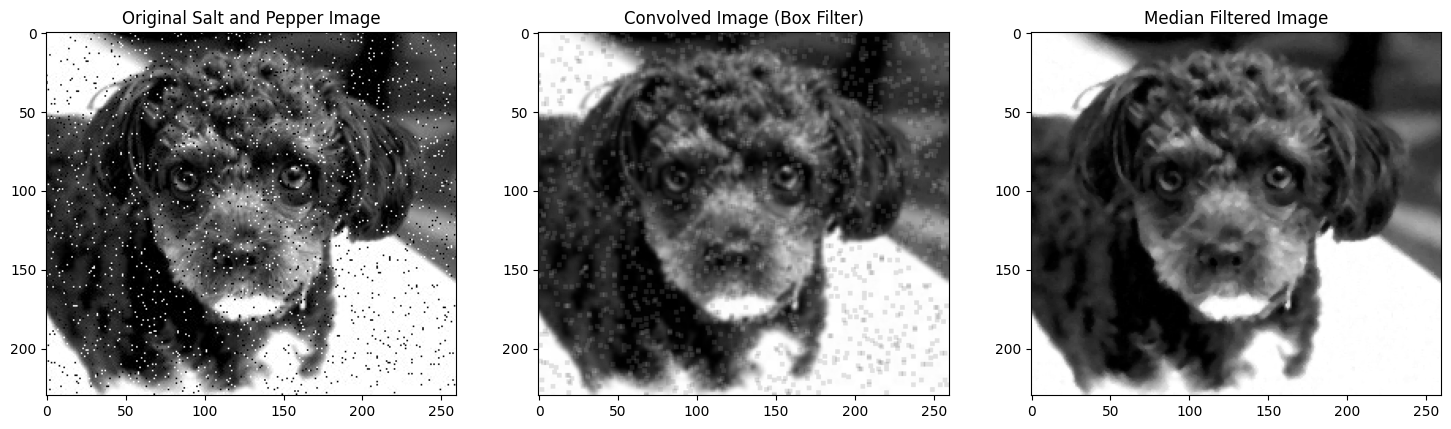

In [4]:
convolved_image = apply_conv2d_box(salt_and_pepper_array)
median_filtered_image = apply_median_filter(salt_and_pepper_array)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(salt_and_pepper_array, cmap='gray')
ax[0].set_title('Original Salt and Pepper Image')
ax[1].imshow(convolved_image, cmap='gray')
ax[1].set_title('Convolved Image (Box Filter)')
ax[2].imshow(median_filtered_image, cmap='gray')
ax[2].set_title('Median Filtered Image')
plt.show()

## Teilaufgabe 2: Automatische Schwellenwertfindung (Thresholding)

Nachdem wir im ersten Schritt das Rauschen im Bild reduziert haben, ist der nächste typische Schritt der Bildanalyse die **Segmentierung**. Das Ziel ist es, das Bild in sinnvolle Bereiche zu unterteilen. Die grundlegendste Form der Segmentierung ist die **Binarisierung**: Wir teilen das Bild in genau zwei Klassen auf: **Vordergrund** (Objekte von Interesse) und **Hintergrund**.

Dies geschieht durch Anwenden eines **Schwellenwerts (Thresholds)** $T$. Jedes Pixel $I(i, j)$ wird überprüft:
* Ist $I(i, j) > T$, wird es dem Vordergrund (z.B. Weiß, Wert 255) zugeordnet.
* Ist $I(i, j) \leq T$, wird es dem Hintergrund (z.B. Schwarz, Wert 0) zugeordnet.

Die zentrale Herausforderung ist: Wie findet man den **optimalen Schwellenwert** $T$ automatisch? Ein manuell gewählter Wert funktioniert vielleicht für ein Bild, aber scheitert bei unterschiedlichen Lichtverhältnissen.

In dieser Aufgabe werden wir zwei fundamentale Algorithmen implementieren, um $T$ automatisch aus den Bilddaten (dem Histogramm) abzuleiten.

### Vorbereitung: Das Histogramm

Beide Methoden basieren nicht auf dem Bild selbst, sondern auf dessen **Histogramm**. Das Histogramm $h(g)$ zählt, wie oft jeder Grauwert $g$ (von 0 bis 255) im Bild vorkommt. Bevor Sie die Algorithmen implementieren, werden Sie eine Funktion zur Berechnung des Histogramms eines Bildes erstellen.

### 1. Der iterative Algorithmus

Dieser Ansatz ist ein intuitives, schrittweises Verfahren, um sich einem stabilen Schwellenwert anzunähern.

Der Algorithmus funktioniert (vereinfacht) wie folgt:
1.  **Starte** mit einer ersten Schätzung für $T$ (z.B. dem mittleren Grauwert des gesamten Bildes).
2.  **Segmentiere** das Bild mit diesem $T$ in zwei Gruppen: $G_1$ (Pixel $\leq T$) und $G_2$ (Pixel $> T$).
3.  **Berechne** den mittleren Grauwert $\mu_1$ von $G_1$ und den mittleren Grauwert $\mu_2$ von $G_2$.
4.  **Setze** einen neuen Schwellenwert $T_{\text{neu}} = \frac{\mu_1 + \mu_2}{2}$.
5.  **Wiederhole** die Schritte 2-4, bis sich $T$ nicht mehr oder nur noch minimal ändert (Konvergenz).

### 2. Die Methode von Otsu

Die **Methode von Otsu** ist ein "intelligenterer" und sehr weit verbreiteter statistischer Ansatz. Otsus Methode analysiert das **Histogramm**, um die **optimale Trennung** zwischen Vorder- und Hintergrund zu finden.

Die Kernidee ist: Der Algorithmus testet jeden möglichen Grauwert $T$ (von 0 bis 255) als potenziellen Schwellenwert. Um dies effizient zu tun, nutzt der Algorithmus **kumulative Summen** (oft als kumulatives Histogramm bezeichnet), die Sie ebenfalls berechnen werden:

1.  **Normalisiertes Histogramm (Wahrscheinlichkeiten)** $p(g)$: Der Anteil jedes Grauwerts an der Gesamtpixelzahl.
2.  **Kumulative Summe (Anteil)** $w(T) = \sum_{g=0}^{T} p(g)$: Der prozentuale Anteil der Pixel, die zur Klasse 1 (Hintergrund) gehören, wenn bei $T$ getrennt wird.
3.  **Kumulative Summe (Mittelwerte)** $\mu(T) = \sum_{g=0}^{T} g \cdot p(g)$: Die Summe der Grauwerte (gewichtet mit ihrer Wahrscheinlichkeit) bis zum Schwellenwert $T$.

Mit diesen Hilfsgrößen testet der Algorithmus jeden Schwellenwert $T$ und berechnet die **Inter-Klassen-Varianz** $\sigma^2_b(T)$ (also den "Abstand" zwischen den beiden Klassen). Die Formel vereinfacht sich durch die kumulativen Summen drastisch:

$$\sigma^2_b(T) = \frac{[\mu_{\text{total}} \cdot w(T) - \mu(T)]^2}{w(T) \cdot (1 - w(T))}$$

* $\mu_{\text{total}}$ ist der mittlere Grauwert des gesamten Bildes.
* $w(T)$ ist der Pixelanteil der Hintergrundklasse (aus der kumulativen Summe 2).
* $\mu(T)$ ist der gewichtete Mittelwert der Hintergrundklasse (aus der kumulativen Summe 3).

Das Ziel ist, denjenigen Schwellenwert $T$ zu finden, der diesen Wert $\sigma^2_b(T)$ **maximiert**. Dieser $T$ gilt als der beste Schwellenwert, um Vorder- und Hintergrund statistisch zu trennen.

---

Ihre Aufgabe ist es, zunächst das Histogramm und die kumulativen Summen zu berechnen und anschließend beide Thresholding-Methoden zu implementieren. Vergleichen Sie die Ergebnisse der beiden Verfahren.


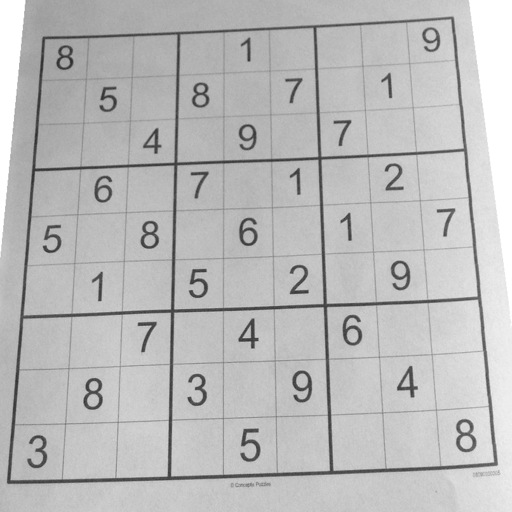

In [5]:
sudoku = Image.open("sudoku.png").convert("L").resize((512, 512))
sudoku_array = np.array(sudoku)
sudoku

In [ ]:
from numpy import histogram

# Wie oft kommt jeder Grauwert von 0 bis 255 im Bild vor?
def calculate_histogram(img_array: np.ndarray, is_normalized: bool = False) -> np.ndarray:

    histogram = np.zeros(256, dtype=int)
   
    pixel_values = img_array.flatten() # Bild in 1D-Liste umwandeln

    for value in pixel_values:
        # Häufigkeit jedes Grauwerts zählen
        histogram[value] = histogram[value] + 1

    if is_normalized:
        return histogram / img_array.size


    return histogram








def calculate_cumulative_histogram(histogram: np.ndarray) -> np.ndarray:
  
    cumulative = np.zeros_like(histogram)

     # erster Wert bleibt gleich (weil es ja keinen Wert davor gibt, den man addieren kann)
    cumulative [0] = histogram [0]
    
    # alle 256 Grauwerte durchlaufen
    for i in range (1,256):
        cumulative [i] = cumulative [i-1] + histogram [i] # Aufsummierung

    return cumulative









def find_threshold_iterative(cumulative_histogram: np.ndarray, max_iterations=20) -> int:
    
    # Anfangsschwellwert (gewichteter Mittelwert aller Grauwerte)
    total = cumulative_histogram.sum()                              
    T = cumulative_histogram.mean()
    T_new = T     


    # Iterationen zur Schwellwertanpassung
    for i in range(max_iterations):

        w1 = cumulative_histogram[cumulative_histogram <= T]                 # Anzahl Pixel <= T (gehören zur dunklen Gruppe)
        w2 = cumulative_histogram[cumulative_histogram >T]                 # Anzahl Pixel > T  (gehöhren zur hellen Gruppe)
       
        if w1.sum() == 0 or w2.sum() == 0:
            break                                        # eine Gruppe leer → Abbruch


        mu1 = w1.mean()
        mu2 = w2.mean()



        T_new = (mu1 + mu2) / 2.0                        # neuer Schwellenwert
   
        if abs(T_new - T) < 0.5:                         # Konvergenzbedingung
            T = T_new
            break

        T = T_new                                        

    return int(np.clip(round(T_new * 255), 0, 255))


"""
bsp für find_threshold_iterative Ablauf:

Grauwert:      0   1   2   3   4   5
Histogram:     5   8   2   1   0   4
Cumulative:    5  13  15  16  16  20

Total Pixel = 20
Also normalisiert wäre z. B.:

cum_norm = cumulative / total
= [0.25, 0.65, 0.75, 0.80, 0.80, 1.00]





Schritt A: Starterschwellwert

T = cumulative_histogram.mean()

Mean = Durchschnitt aller Werte:
(5 + 13 + 15 + 16 + 16 + 20) / 6 = 85 / 6 ≈ 14.17


Also Startwert:
T = 14.17







Schritt B: Gruppen bilden

w1 = Werte <= 14.17
w2 = Werte > 14.17

→ w1 = [5, 13]
→ w2 = [15, 16, 16, 20]







Schritt C: Mittelwerte

mu1 = mean([5, 13]) = 9
mu2 = mean([15, 16, 16, 20]) = 16.75




Schritt D: Neuer Threshold
T_new = (mu1 + mu2) / 2
= (9 + 16.75) / 2
= 12.875



Schritt E: Convergence?
|12.875 – 14.17| = 1.295
Nicht < 0.5 → also weiter.



Schritt F: Nächster Zyklus

Trennen:

w1 = [5,13,?] — Werte neu prüufen

w2 = […]


Schritt G: Rückgabe in echten Grauwerten
T_final = T_new * 255





"""












def find_threshold_by_otsu(histogram: np.ndarray, cumulative_histogram: np.ndarray) -> int:
    # Normierung (Wahrscheinlichkeiten)
    total = float(np.sum(histogram))
    if total == 0:
        return 0
    p = (histogram / total).astype(float)
    

    # Hilfsarrays
    P = np.cumsum(p)                         # kumulative Wahrscheinlichkeit bis T (P0)
    indices = np.arange(256)                
    M = np.cumsum(indices * p)               # kumulierte Summe i*p(i) bis T
    M_total = M[255]                         # globaler Mittelwert

    best_threshold = 0
    best_variance = -1.0

    for T in range(256):
        P0 = P[T]                            # Anteil Pixel ≤ T
        P1 = 1.0 - P0                        # Anteil Pixel > T
        if P0 == 0.0 or P1 == 0.0:
            continue

        mu0 = M[T] / P0                      # Mittelwert dunkle Klasse
        mu1 = (M_total - M[T]) / P1          # Mittelwert helle Klasse

        variance = P0 * P1 * (mu0 - mu1) ** 2  # Between-class-Varianz
        if variance > best_variance:
            best_variance = variance
            best_threshold = T

    return int(best_threshold)





"""
bsp für find_threshold_by_otsu Ablauf:



Grauwert:    0  1  2  3 
histogram:  [4, 1, 0, 5]

total = float(np.sum(histogram))
if total == 0:
    return 0
p = (histogram / total).astype(float)

total = 4 + 1 + 0 + 5 = 10   # insgesamt 10 Pixel im Bild

p[0] = 4/10 = 0.4
p[1] = 1/10 = 0.1
p[2] = 0/10 = 0.0
p[3] = 5/10 = 0.5

p = [0.4, 0.1, 0.0, 0.5]

----------------------------------------------------

P = np.cumsum(p)               
indices = np.arange(256)                
M = np.cumsum(indices * p)     
M_total = M[255]


indices = [0, 1, 2, 3]
p       = [0.4, 0.1, 0.0, 0.5]

Rechnung:

P[0] = 0.4

P[1] = 0.4 + 0.1 = 0.5

P[2] = 0.5 + 0.0 = 0.5

P[3] = 0.5 + 0.5 = 1.0


P = [0.4, 0.5, 0.5, 1.0]




indices * p = [0*0.4, 1*0.1, 2*0.0, 3*0.5]
            = [0.0,   0.1,   0.0,   1.5]

Dann np.cumsum:

M[0] = 0.0

M[1] = 0.0 + 0.1 = 0.1

M[2] = 0.1 + 0.0 = 0.1

M[3] = 0.1 + 1.5 = 1.6


------------------------------------------
Bsp : T = 1

P  = [0.4, 0.5, 0.5, 1.0]

M  = [0.0, 0.1, 0.1, 1.6]

M_total = 1.6

1. Klassenwahrscheinlichkeiten

P0 = P[T] = P[1] = 0.5    
P1 = 1.0 - P0 = 0.5       


2. Klassenmittelwerte

mu0 = M[T] / P0 = M[1] / 0.5    = 0.1 / 0.5 = 0.2

M[1] = Summe(i * p(i) für i ≤ 1):
0*0.4 + 1*0.1 = 0 + 0.1 = 0.1



mu1 = (M_total - M[T]) / P1  = (1.6 - 0.1) / 0.5 =    1.5 / 0.5 = 3.0

variance = P0 * P1 * (mu0 - mu1)**2
         = 0.5 * 0.5 * (0.2 - 3.0)**2
         = 0.25 * ( -2.8 )^2
         = 0.25 * 7.84
         = 1.96

         



"""







  


'\nbsp für find_threshold_by_otsu Ablauf:\n\n\n\nGrauwert:    0  1  2  3 \nhistogram:  [4, 1, 0, 5]\n\ntotal = float(np.sum(histogram))\nif total == 0:\n    return 0\np = (histogram / total).astype(float)\n\ntotal = 4 + 1 + 0 + 5 = 10   # insgesamt 10 Pixel im Bild\n\np[0] = 4/10 = 0.4\np[1] = 1/10 = 0.1\np[2] = 0/10 = 0.0\np[3] = 5/10 = 0.5\n\np = [0.4, 0.1, 0.0, 0.5]\n\n----------------------------------------------------\n\nP = np.cumsum(p)               \nindices = np.arange(256)                \nM = np.cumsum(indices * p)     \nM_total = M[255]\n\n\nindices = [0, 1, 2, 3]\np       = [0.4, 0.1, 0.0, 0.5]\n\nRechnung:\n\nP[0] = 0.4\n\nP[1] = 0.4 + 0.1 = 0.5\n\nP[2] = 0.5 + 0.0 = 0.5\n\nP[3] = 0.5 + 0.5 = 1.0\n\n\nP = [0.4, 0.5, 0.5, 1.0]\n\n\n\n\nindices * p = [0*0.4, 1*0.1, 2*0.0, 3*0.5]\n            = [0.0,   0.1,   0.0,   1.5]\n\nDann np.cumsum:\n\nM[0] = 0.0\n\nM[1] = 0.0 + 0.1 = 0.1\n\nM[2] = 0.1 + 0.0 = 0.1\n\nM[3] = 0.1 + 1.5 = 1.6\n\n\n---------------------------------------

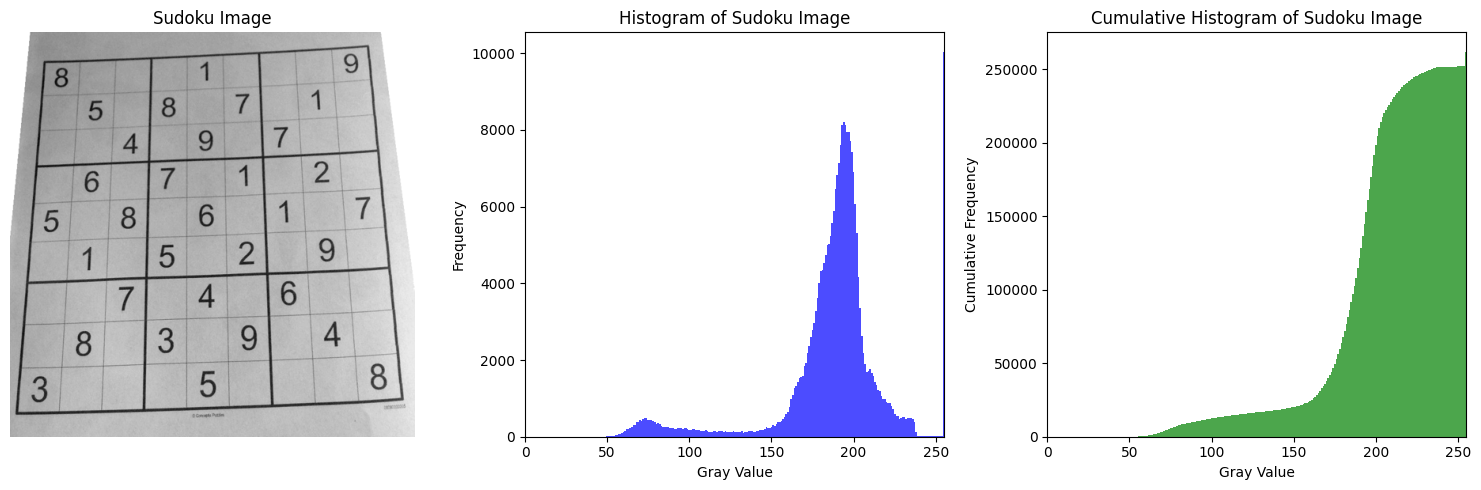

In [7]:
histogram = calculate_histogram(sudoku_array)
cumulative_histogram = calculate_cumulative_histogram(histogram)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(sudoku_array, cmap='gray')
ax[0].set_title('Sudoku Image')
ax[0].axis('off')

ax[1].bar(range(256), histogram, width=1.0, color='blue', alpha=0.7)
ax[1].set_xlabel('Gray Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Sudoku Image')
ax[1].set_xlim(0, 255)

ax[2].bar(range(256), cumulative_histogram, width=1.0, color='green', alpha=0.7)
ax[2].set_xlabel('Gray Value')
ax[2].set_ylabel('Cumulative Frequency')
ax[2].set_title('Cumulative Histogram of Sudoku Image')
ax[2].set_xlim(0, 255)

plt.tight_layout()
plt.show()

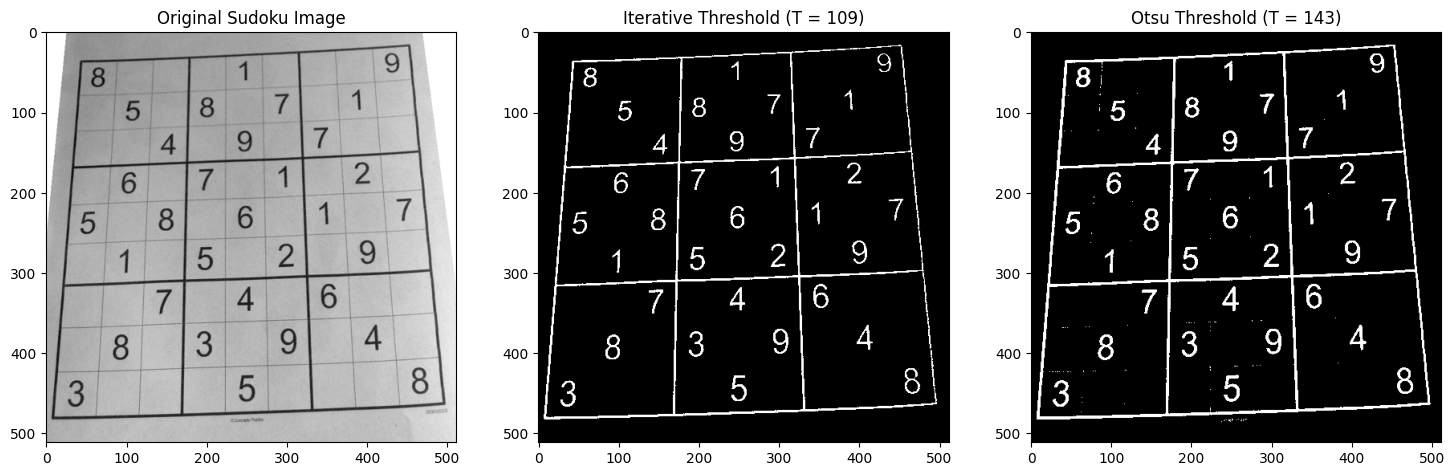

In [8]:
normalized_histogram = calculate_histogram(sudoku_array, is_normalized=True)
normalized_cumulative_histogram = calculate_cumulative_histogram(normalized_histogram)

iterative_threshold = find_threshold_iterative(normalized_cumulative_histogram)
otsu_threshold = find_threshold_by_otsu(normalized_histogram, normalized_cumulative_histogram)

# Apply thresholding
iterative_segmented = (sudoku_array <= iterative_threshold).astype(np.uint8) * 255
otsu_segmented = (sudoku_array <= otsu_threshold).astype(np.uint8) * 255

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(sudoku_array, cmap='gray')
ax[0].set_title('Original Sudoku Image')
ax[1].imshow(iterative_segmented, cmap='gray')
ax[1].set_title(f'Iterative Threshold (T = {iterative_threshold})')
ax[2].imshow(otsu_segmented, cmap='gray')
ax[2].set_title(f'Otsu Threshold (T = {otsu_threshold})')
plt.show()

## Teilaufgabe 3: Morphologische Operatoren

Nachdem wir in Teil 2 gelernt haben, wie man ein Graustufenbild in ein **Binärbild** (Schwarz-Weiß) umwandelt, ist der nächste Schritt oft die "Bereinigung" dieses Bildes. Das Ergebnis einer Schwellenwertbildung ist selten perfekt: Es kann kleine, isolierte "Rauschpixel" (sowohl schwarze Löcher im Vordergrund als auch weiße Flecken im Hintergrund) oder dünne "Brücken", die Objekte fälschlicherweise verbinden, enthalten.

Hier kommen **morphologische Operatoren** ins Spiel. Dies sind nicht-lineare Operationen, die auf der **Form** (oder Morphologie) von Objekten in einem Bild arbeiten. Sie werden verwendet, um die Struktur von Binärbildern zu analysieren und zu modifizieren.

### Das Strukturelement (SE)

Alle morphologischen Operationen basieren auf einem **Strukturelement (SE)**. Dies ist ein kleiner "Kernel" (ähnlich wie unser Faltungskern), der als "Sonde" über das Bild geschoben wird. Für unsere Aufgabe verwenden wir ein einfaches 3x3-Quadrat als SE:

$$SE = \begin{pmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{pmatrix}$$

### Die Grundoperationen: Erosion und Dilatation

Die beiden fundamentalen Operationen, aus denen fast alle anderen abgeleitet werden, sind Erosion und Dilatation.

1.  **Erosion (Schrumpfen)**:
    Die Erosion *verkleinert* die Grenzen von Vordergrundobjekten (weiße Bereiche). Ein Pixel im Ausgabebild wird *nur dann* auf Weiß (1) gesetzt, wenn das **gesamte** Strukturelement, zentriert auf diesem Pixel, **vollständig** auf Vordergrundpixel im Eingabebild passt.
    * **Effekt**: Dünne Linien und isolierte weiße Pixel (Rauschen) werden komplett entfernt. Objekte schrumpfen.

2.  **Dilatation (Wachsen)**:
    Die Dilatation *vergrößert* die Grenzen von Vordergrundobjekten. Ein Pixel im Ausgabebild wird auf Weiß (1) gesetzt, wenn das Strukturelement, zentriert auf diesem Pixel, **mindestens ein** Vordergrundpixel im Eingabebild "trifft" (überlappt).
    * **Effekt**: Kleine schwarze Löcher in Objekten werden gefüllt. Objekte wachsen und können miteinander verschmelzen.

### Unsere Ziel-Operation: Die Öffnung (Opening)

In dieser Aufgabe implementieren wir die **Öffnung (Opening)**. Diese Operation ist definiert als eine **Erosion, *gefolgt* von einer Dilatation** (mit demselben Strukturelement).

Warum diese Kombination?
1.  Die **Erosion** entfernt zunächst alle kleinen Rauschpixel (wie in Teil 1 das "Salz"-Rauschen, nur jetzt im Binärbild) und bricht dünne Brücken zwischen Objekten auf. Größere Objekte schrumpfen dabei.
2.  Die anschließende **Dilatation** vergrößert die verbliebenen (bereinigten) Objekte wieder auf ungefähr ihre ursprüngliche Größe. Wichtig dabei: Das Rauschen, das im ersten Schritt entfernt wurde, "wächst nicht nach"!

Der Nettoeffekt der Öffnung ist also die **Entfernung kleiner Objekte und die Glättung von Konturen**, ohne die Größe der Hauptobjekte signifikant zu verändern.

---

Ihre Aufgabe ist es, die Operationen **Erosion** und **Dilatation** von Grund auf zu implementieren und diese dann zur **Öffnung** zu kombinieren. Wenden Sie Ihre Implementierung auf die Binärbilder aus Teil 2 an und beobachten Sie den Bereinigungseffekt.

In [9]:
def apply_binary_erosion(img: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    if structuring_element.shape[0] != 3 or structuring_element.shape[1] != 3:
        raise ValueError("Structuring element must be of size 3x3.")

    # Ausgabe-Bild
    eroded_img = np.zeros_like(img)
   
    # Bild mit 0-Padding (Rand)
    padded_img = np.pad(img, pad_width=1, mode="constant", constant_values=0)

    height, width = img.shape

    se_range = range(-1, 2)
    

    for y in range(height):
        for x in range(width):
            # Man geht von Zentrum (y,x) im Original aus → im gepaddeten Bild ist das (y+1,x+1)
            matches = True

            for dy in se_range:
                for dx in se_range:
                    # Position im SE (Structuring Element)
                    se_val = structuring_element[dy + 1, dx + 1] # dy ∈ -1,0,1 → umwandeln zu 0,1,2 (Index in SE)

                    if se_val == 1:
                        # Entsprechendes Nachbarpixel im gepaddeten Bild
                        neighbor = padded_img[y + 1 + dy, x + 1 + dx]
                        if neighbor != 1:
                            matches = False
                            break
                if not matches:
                    break

            # Wenn alle 1en im SE über 1en im Bild liegen → Pixel bleibt 1, sonst 0
            if matches:
                eroded_img[y, x] = 1
            else:
                eroded_img[y, x] = 0

    return eroded_img



"""
bsp Erosion

„Alle SE-1er müssen auf Bild-1ern liegen, sonst → Pixel = 0“
(AND-Logik)

Erosion-Regel:
Lege das SE so über das Bild, dass sein Zentrum auf einem Pixel (y,x) liegt.

• Wenn ALLE Positionen, an denen das SE eine 1 hat, auch im Bild eine 1 haben → Ausgabepixel = 1
• Wenn irgendwo eine SE-1 auf eine Bild-0 trifft → Ausgabepixel = 0

Structuring Element (SE): EIN KREUZ


SE:

0 1 0
1 1 1
0 1 0


Bild (5×5)


img:

0 0 0 0 0
0 1 1 1 0
0 1 1 1 0
0 1 1 1 0
0 0 0 0 0


Pixel (2,2) → in der Mitte

Pixel (1,2) → oben im Block



1) Pixel (2,2) – DIE MITTE

1 1 1
1 1 1
1 1 1

SE :

0 1 0
1 1 1
0 1 0


Jetzt legt man SE über das Fenster:

SE sagt:

Prüfe oben Mitte → Bild oben Mitte = 1 ✔️

Prüfe Mitte links → Bild Mitte links = 1 ✔️

Prüfe Mitte Mitte → Bild Mitte Mitte = 1 ✔️

Prüfe Mitte rechts → Bild Mitte rechts = 1 ✔️

Prüfe unten Mitte → Bild unten Mitte = 1 ✔️

ALLE geforderten SE-1 Positionen liegen über Bild-1en.

Pixel (2,2) bleibt 1




2) Pixel (1,2) – oben in der Mitte

0 0 0
1 1 1
1 1 1


SE :

0 1 0
1 1 1
0 1 0


Prüfen der geforderten 1-Positionen:

Bild oben Mitte = 0 
→ FAIL

Eine einzige 0 reicht → Erosion sagt:

Pixel (1,2) wird 0



Pixel (2,2) → 1

Pixel (1,2) → 0

"""











def apply_binary_dilation(img: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    if structuring_element.shape[0] != 3 or structuring_element.shape[1] != 3:
        raise ValueError("Structuring element must be of size 3x3.")

    dilated_img = np.zeros_like(img)

    padded_img = np.pad(img, pad_width=1, mode="constant", constant_values=0)

    height, width = img.shape
    se_range = range(-1, 2) 
    

    for y in range(height):
        for x in range(width):
            pixel_wird_1 = False

            for dy in se_range:
                for dx in se_range:
                    # Prüfe nur dort, wo das SE eine 1 hat
                    if structuring_element[dy + 1, dx + 1] == 1:
                        neighbor = padded_img[y + 1 + dy, x + 1 + dx]

                        # Wenn irgendein Nachbar 1 ist → Pixel wird 1
                        if neighbor == 1:
                            pixel_wird_1 = True
                            break
                if pixel_wird_1:
                    break

            dilated_img[y, x] = 1 if pixel_wird_1 else 0

    return dilated_img




"""
bsp Dilation

„Es reicht, wenn irgendeine SE-1 auf einer Bild-1 liegt → Pixel = 1“
(OR-Logik)

Dilation Regeln:

Wenn IRGENDEINE SE-1 auf eine Bild-1 trifft → Pixel wird 1.
Erst wenn GAR KEIN Bild-1 in der SE-Nachbarschaft liegt, bleibt Pixel 0


SE:

0 1 0
1 1 1
0 1 0



img:

0 0 0 0 0
0 1 1 1 0
0 1 1 1 0
0 1 1 1 0
0 0 0 0 0




Pixel: (2,2) – das Zentrum

1 1 1
1 1 1
1 1 1


SE:

0 1 0
1 1 1
0 1 0

Dilation(2,2) = 1








Pixel : (1,1) — innen am Rand

0 0 0
0 1 1
0 1 1



SE :

0 1 0
1 1 1
0 1 0

Prüfen:

oben Mitte → 0 

Mitte links → 0 

Mitte Mitte → 1 

Nur ein einziger Treffer reicht → Pixel wird 1.

Dilation(1,1) = 1



"""





def apply_binary_opening(img: np.ndarray, structuring_element: np.ndarray) -> np.ndarray:
    # Schritt 1: Erosion
    eroded = apply_binary_erosion(img, structuring_element)

    # Schritt 2: Dilatation auf das erodierte Bild
    opened = apply_binary_dilation(eroded, structuring_element)

    return opened



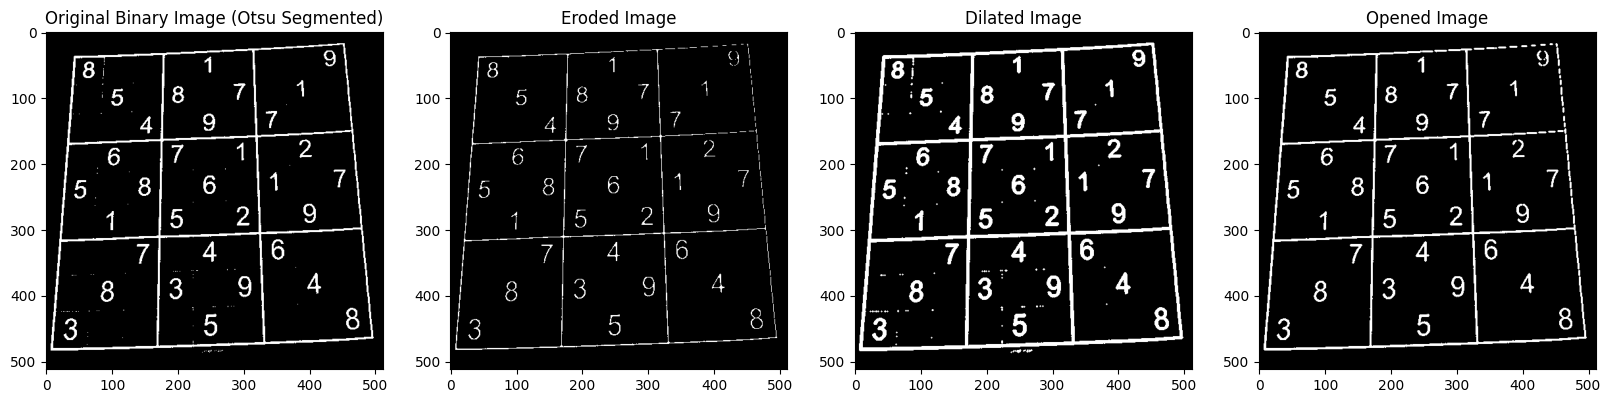

In [10]:
otsu_segmented = (sudoku_array <= otsu_threshold).astype(np.bool) # not * 255 because we are in binary space now

kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)


eroded_img = apply_binary_erosion(otsu_segmented, structuring_element=kernel)
dilated_img = apply_binary_dilation(otsu_segmented, structuring_element=kernel)
opened_img = apply_binary_opening(otsu_segmented, structuring_element=kernel)

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
ax[0].imshow(otsu_segmented, cmap='gray')
ax[0].set_title('Original Binary Image (Otsu Segmented)')
ax[1].imshow(eroded_img, cmap='gray')
ax[1].set_title('Eroded Image')
ax[2].imshow(dilated_img, cmap='gray')
ax[2].set_title('Dilated Image')
ax[3].imshow(opened_img, cmap='gray')
ax[3].set_title('Opened Image')
plt.show()


## Teilaufgabe 4: Die Hough-Transformation zur Linienerkennung

Nachdem wir unser Bild gefiltert (Teil 1), binarisiert (Teil 2) und morphologisch bereinigt (Teil 3) haben, besitzen wir nun eine saubere Darstellung der Bildobjekte. Der nächste logische Schritt in vielen Bildverarbeitungs-Pipelines ist die **Merkmalsextraktion**: Wir wollen die Objekte nicht nur *sehen*, sondern sie auch *beschreiben* oder *finden*.

In dieser letzten Aufgabe implementieren wir die **Hough-Transformation**, eine fundamentale und leistungsstarke Technik, um geometrische Grundformen – in unserem Fall **Linien** – in einem Bild zu detektieren.

### Die Herausforderung

Das Finden von Linien in einem Bild ist nicht trivial. Eine Linie kann lückenhaft sein (gestrichelt), teilweise verdeckt oder durch Rauschen gestört sein. Ein Algorithmus, der einfach versucht, benachbarte Pixel zu verbinden, würde hier schnell scheitern.

### Die Kernidee: Vom Bildraum zum Parameterraum

Die Hough-Transformation löst dieses Problem durch einen cleveren "Trick": Sie verwendet ein **Abstimmungsverfahren (Voting)**. Statt im Bildraum (x, y) nach Linien zu suchen, wandelt sie jeden Punkt in einen "Parameterraum" um und lässt die Punkte dort für alle Linien "abstimmen", zu denen sie gehören *könnten*.

Für die Linienerkennung verwenden wir die **Hessesche Normalform** zur Darstellung einer Linie:

$$\rho = x \cdot \cos(\theta) + y \cdot \sin(\theta)$$

* $(x, y)$ sind die Koordinaten eines Pixels im Bild.
* $\rho$ (rho) ist der senkrechte Abstand der Linie vom Ursprung (0, 0).
* $\theta$ (theta) ist der Winkel der Normalen (der Senkrechten) dieser Linie zur x-Achse.



**Der Clou:**
1.  Ein einzelner Punkt $(x, y)$ im Bildraum entspricht einer **Sinuskurve** im $(\rho, \theta)$-Parameterraum (dem "Hough-Raum"), denn für ein festes $(x, y)$ gibt es unendlich viele Linien (unendlich viele Paare von $\rho$ und $\theta$), die durch diesen Punkt gehen.
2.  Liegen mehrere Punkte $(x_1, y_1), (x_2, y_2), ...$ im Bildraum auf derselben Linie (z.B. mit den Parametern $\rho_{\text{linie}}$ und $\theta_{\text{linie}}$), **schneiden sich ihre jeweiligen Sinuskurven** im Hough-Raum alle in *genau einem Punkt*: $(\rho_{\text{linie}}, \theta_{\text{linie}})$.

### Der Akkumulator

Ihre Aufgabe ist es, diesen Abstimmungsprozess zu implementieren:
1.  Sie erstellen eine 2D-Matrix, den sogenannten **Akkumulator**. Dieses 2D-Histogramm repräsentiert den diskretisierten $(\rho, \theta)$-Raum (z.B. $\theta$ von $0^\circ$ bis $180^\circ$ und $\rho$ von $-D$ bis $+D$, wobei $D$ die Bilddiagonale ist).
2.  Sie iterieren über **jedes weiße Pixel** $(x, y)$ in Ihrem **bereinigten Binärbild** (dem Ergebnis der Öffnung aus Teil 3).
3.  Für jedes dieser Pixel berechnen Sie die zugehörige Sinuskurve im Hough-Raum (indem Sie $\theta$ von $0^\circ$ bis $180^\circ$ durchlaufen und das jeweilige $\rho$ berechnen).
4.  Für jeden Punkt $(\rho, \theta)$ auf dieser Kurve **erhöhen Sie den Zähler (Vote)** in der entsprechenden Zelle des Akkumulators.

Am Ende dieses Vorgangs entsprechen die Zellen im Akkumulator mit den **höchsten Werten (Peaks)** den dominantesten Linien im Bild. Die Koordinaten $(\rho, \theta)$ dieser Peaks sind die Parameter der gefundenen Linien.

**Warum das Bild aus Teil 3?** Wir verwenden das Ergebnis der morphologischen Öffnung, da es Rauschpixel entfernt hat. Jedes Rauschpixel würde fälschlicherweise für hunderte von Linien "stimmen" und den Akkumulator "verschmutzen". Durch die saubere Eingabe wird unsere Linienerkennung wesentlich robuster und genauer.

In [11]:
def apply_hough_transform(binary_image: np.ndarray, top_k: int = 5) -> tuple[list[tuple[int, int]], np.ndarray]:

    height, width = binary_image.shape

    # maximale mögliche Entfernung ρ (Bilddiagonale)
    # ρ kann negativ oder positiv sein, je nach Lage der Linie
    # bsp: Bildgröße 100×100 → Diagonale ≈ 141 
    # math.sqrt bedeutet Wurzeln ziehen
    
    D = math.sqrt(height**2 + width**2)

    # Also ρ kann von −141 bis +141 gehen.
    max_acc = int(D)

    
    max_angle_deg = 180

    # Hough-Akkumulator: Zeilen = ρ (mögliche Linie), Spalten = θ (Winkeln)
    hough_space = np.zeros((2 * max_acc, max_angle_deg), dtype=int)

    # --- Voting: über alle weißen Pixel (255) im Binärbild laufen ---
    for y in range(height):
        for x in range(width):
            if binary_image[y, x] != 255:   # nur Kantenpixel (bzw Wenn dieser Pixel NICHT weiß (255) ist, überspringe ihn.“)
                continue

            # für jeden Winkel θ die passende ρ-Linie berechnen
            for theta_deg in range(max_angle_deg): # 180° bedeutet es gibt 180 Werten

                theta_rad = math.radians(theta_deg) # Umrechnen in Bogenmaß

                rho = x * math.cos(theta_rad) + y * math.sin(theta_rad) # Formel für Hough-Transformation.

                rho_int = int(round(rho))

                # Indexverschiebung, da ρ in [-max_acc, +max_acc] liegen kann (bzw Python-Arrays dürfen KEINE negativen Indizes haben)
                rho_index = rho_int + max_acc

                # nur gültige Indizes voten lassen (Die (ρ, θ) Komibnation)  (Die Linien mit den meisten Stimmen sind die echten Linien im Bild.)
                if 0 <= rho_index < 2 * max_acc:
                    hough_space[rho_index, theta_deg] += 1

    # --- stärkste Peaks im Akkumulator heraussuchen ---
    hough_lines: list[tuple[int, int]] = []

    for _ in range(top_k):
        flat_index = np.argmax(hough_space)  # stärkster Wert
        if hough_space.flat[flat_index] == 0:
            break  # nichts Sinnvolles mehr drin

        rho_index, theta_index = np.unravel_index(flat_index, hough_space.shape) # argmax gibt uns nur einen linearen (flachen) Index zurück, z. B. 2420. Man braucht aber Zeile = p -index und Spalte θ. Deswegen müssen wir den flachen index wieder in (ρ, θ) umwandeln.

        rho = rho_index - max_acc          # zurück in echten ρ-Bereich
        theta = theta_index                # θ bleibt im Gradmaß

        hough_lines.append((rho, theta))

        hough_space[rho_index, theta_index] = 0  # Peak „löschen“, damit nächster gefunden wird

    return hough_lines, hough_space



    



In [12]:
def visualize_hough_lines(image_array: np.ndarray, hough_lines: np.ndarray, hough_space: np.ndarray):
    """Visualize detected Hough lines on the image."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot original image with detected lines
    ax1.imshow(image_array, cmap='gray')

    height, width = image_array.shape

    for rho, theta in hough_lines:
        theta = np.deg2rad(theta)
        # Convert polar coordinates to line endpoints
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        # Calculate line endpoints (extended beyond image boundaries)
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2, alpha=0.7)

    ax1.set_xlim(0, width)
    ax1.set_ylim(height, 0)
    ax1.set_title(f'Detected Hough Lines (top {len(hough_lines)})')
    ax2.imshow(hough_space, cmap='hot', aspect='auto')
    ax2.set_xlabel('Theta (degrees)')
    ax2.set_ylabel('Rho')
    ax2.set_title('Hough Space')
    plt.tight_layout()
    plt.show()

In [13]:
# prepare data
normalized_histogram = calculate_histogram(sudoku_array, is_normalized=True)
normalized_cumulative_histogram = calculate_cumulative_histogram(normalized_histogram)

iterative_threshold = find_threshold_iterative(normalized_cumulative_histogram)
binary_img = (sudoku_array <= iterative_threshold).astype(np.uint8) * 255

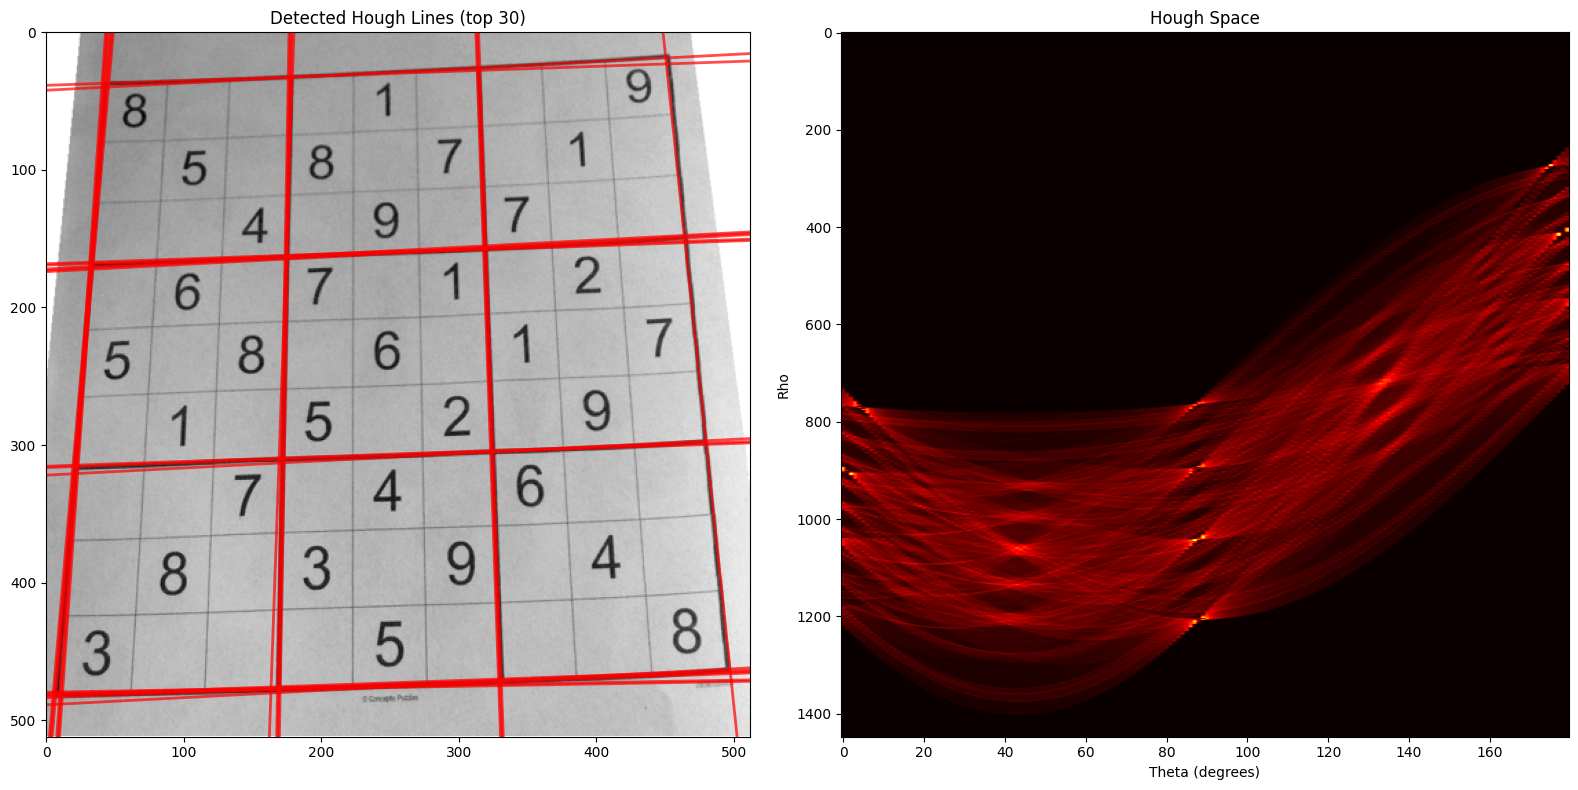

In [14]:
hough_lines, hough_space = apply_hough_transform(binary_img, top_k=30)
visualize_hough_lines(sudoku_array, hough_lines, hough_space)